# Problem StATEMENT: Gesture Recognition
This is a `Gesture Recognition` problem. We are provided video clips dataset in the form of RGB image sequences. We have 5 different types of gestures to be classified viz, 
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume

We would try to solve this problem using 2 different deep learning architectures, 3DCNN and CNN+GRU. These approach are very well know to be able to tackle image sequence datasets.


In [1]:
# Importing Dependancies

import numpy as np
import os
from skimage.transform import resize, rotate
import imageio
from imageio import imread
import datetime
import matplotlib.pyplot as plt

np.random.seed(100)
import random as rn
rn.seed(100)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(100)

# 1. Reading Dataset

In [2]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We can import data into Google Colab with two methods. One, directly reading data from Google Drive and second includes loading data into local instance from our system or google drive. 

The second method should be preferred if data is quite large in size, which is our case here. Hence, we would be loading the data into local instance from google drive. This would speed up our model training. 

Here we have already got our data in zip format loaded in Google drive. We would extract it into the local instance machine.

In [3]:
# Extracting the into local instance machine from Google drive
!unzip "gdrive/My Drive/Project_data.zip" -d ""


Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [4]:
# Predefining model parameters

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10 # batch size of train/validation set 
img_height = 75 # image height to be feed into model
img_width = 75 # image width to be feed into model
seq_l = np.arange(0, 30, 2) # Input image sequence (original image sequence is having 30 images)
seq_len = len(seq_l) # Input image sequence length

## Image Augmentation


Training dataset can be augmented to improve the performance of the model. We would try to augment each image string by translating(horizontal and vertical) and rescaling.

In [5]:
# Defining Image Augmentor

from skimage import transform 

def augment(image):

  shift_x, shift_y = image.shape[0]/10, image.shape[1]/10
  # translation by certain units
  matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
  
  #scaling
  scale_transforms = transform.AffineTransform(scale=(0.9, 0.9))
  scale_matrix = matrix_to_topleft + scale_transforms
  scale_image_zoom_in = transform.warp(image, scale_matrix)

  aug_img= resize(scale_image_zoom_in, (image.shape[0],image.shape[1],3))

  return (aug_img)

## Image Data Generator

Image data generator uses the concept of `generator` in python. Generators are functions which can `yield` the output sequentially whenever it is required. If we use `return` while defining any function, then output would be created directly and stored in that object, which can fillup all the cache memory. Generator yields output, means it stores generator object which finds the require data if/whenever called.

In [6]:
# Defining image Generator

def generator(source_path, folder_list, batch_size, aug=False):  
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_l
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3)) 
            batch_labels = np.zeros((batch_size,5)) 
            # augmentation
            if aug==True:
              batch_data_aug= np.zeros((batch_size,len(img_idx),img_width,img_height,3))
            for folder in range(batch_size): 
                imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])) 
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Crop
                    ima, imb, imc = image.shape
                    crop_image = image[0: ima , imb // 8: - imb // 8, :]

                    # resize
                    res_image = resize(crop_image, (img_width, img_height))
                    
                    batch_data[folder,idx,:,:,0] = (res_image[:,:,0]-np.amin(res_image[:,:,0]))/(np.amax(res_image[:,:,0])-np.amin(res_image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (res_image[:,:,1]-np.amin(res_image[:,:,1]))/(np.amax(res_image[:,:,1])-np.amin(res_image[:,:,1]))
                    batch_data[folder,idx,:,:,2] = (res_image[:,:,2]-np.amin(res_image[:,:,2]))/(np.amax(res_image[:,:,2])-np.amin(res_image[:,:,2]))
                    
                    # augmentation
                    if aug==True:
                      aug_img= augment(res_image)
                      batch_data_aug[folder,idx,:,:,0] = (aug_img[:,:,0]-np.amin(aug_img[:,:,0]))/(np.amax(aug_img[:,:,0])-np.amin(aug_img[:,:,0]))
                      batch_data_aug[folder,idx,:,:,1] = (aug_img[:,:,1]-np.amin(aug_img[:,:,1]))/(np.amax(aug_img[:,:,1])-np.amin(aug_img[:,:,1]))
                      batch_data_aug[folder,idx,:,:,2] = (aug_img[:,:,2]-np.amin(aug_img[:,:,2]))/(np.amax(aug_img[:,:,2])-np.amin(aug_img[:,:,2]))
                
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            if aug==True:
              batch_data=np.concatenate([batch_data,batch_data_aug])
              batch_labels=np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels 
   
        # Remaining data batch
        if len(folder_list)%batch_size !=0:
            batch_size1 = len(folder_list)%batch_size
            for batch in range(num_batches, num_batches+1): 
                batch_data1 = np.zeros((batch_size1,len(img_idx),img_width,img_height,3)) 
                batch_labels1 = np.zeros((batch_size1,5)) 

                # augmentation
                if aug==True:
                  batch_data_aug1= np.zeros((batch_size1,len(img_idx),img_width,img_height,3))
                for folder in range(batch_size1): 
                    imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch*batch_size1)].split(';')[0])) 
                    for idx,item in enumerate(img_idx): 
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        # Crop
                        ima, imb, imc = image.shape
                        crop_image = image[0: ima, imb // 8: - imb // 8, :]
                        # resize
                        res_image = resize(crop_image, (img_width, img_height))

                        batch_data1[folder,idx,:,:,0] = (res_image[:,:,0]-np.amin(res_image[:,:,0]))/(np.amax(res_image[:,:,0])-np.amin(res_image[:,:,0]))
                        batch_data1[folder,idx,:,:,1] = (res_image[:,:,1]-np.amin(res_image[:,:,1]))/(np.amax(res_image[:,:,1])-np.amin(res_image[:,:,1]))
                        batch_data1[folder,idx,:,:,2] = (res_image[:,:,2]-np.amin(res_image[:,:,2]))/(np.amax(res_image[:,:,2])-np.amin(res_image[:,:,2]))

                        # augmentation
                        if aug==True:
                          aug_img= augment(res_image)
                          batch_data_aug1[folder,idx,:,:,0] = (aug_img[:,:,0]-np.amin(aug_img[:,:,0]))/(np.amax(aug_img[:,:,0])-np.amin(aug_img[:,:,0]))
                          batch_data_aug1[folder,idx,:,:,1] = (aug_img[:,:,1]-np.amin(aug_img[:,:,1]))/(np.amax(aug_img[:,:,1])-np.amin(aug_img[:,:,1]))
                          batch_data_aug1[folder,idx,:,:,2] = (aug_img[:,:,2]-np.amin(aug_img[:,:,2]))/(np.amax(aug_img[:,:,2])-np.amin(aug_img[:,:,2]))
                
                    batch_labels1[folder, int(t[folder + (batch*batch_size1)].strip().split(';')[2])] = 1

                if aug==True:
                  batch_data1=np.concatenate([batch_data1,batch_data_aug1])
                  batch_labels1=np.concatenate([batch_labels1,batch_labels1])

                yield batch_data1, batch_labels1

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('validation sequences =', num_val_sequences)

training sequences = 663
validation sequences = 100


We have train set of size 663 and val set of 100.

In [8]:
# Defining train and validation generator objects

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  Project_data/train ; batch size = 10


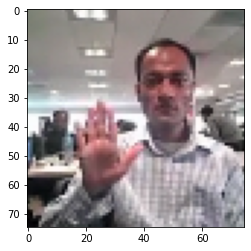

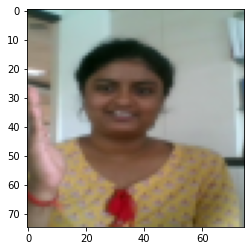

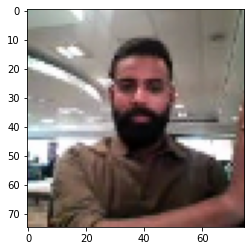

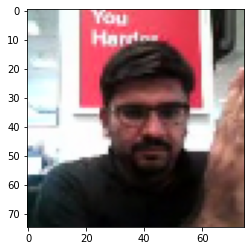

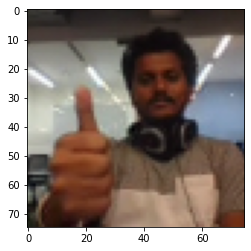

In [9]:
# Checking the output of train generator

for i in range(5):
  plt.imshow(next(train_generator)[0][0][1])
  plt.show()


In [10]:
# Storing Model Evaluation Paramenters

results = []

## 3D-CNN Model Development

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

# model
sample_shape = [seq_len, img_width, img_height, 3]
no_classes = 5

model_3c = tf.keras.Sequential(
    [layers.Conv3D(filters=4, kernel_size=(3,3,3), activation="relu", padding="same", input_shape=sample_shape),
     layers.BatchNormalization(),
     layers.MaxPooling3D(),
     layers.Dropout(0.20),
     layers.Conv3D(filters=8, kernel_size=(3,3,3), activation="relu", padding="same", input_shape=sample_shape),
     layers.BatchNormalization(),
     layers.MaxPooling3D(),
     layers.Dropout(0.20),
     layers.Flatten(),
     layers.Dense(128, activation='relu'),
     layers.Dropout(0.25),
     layers.Dense(no_classes, activation='softmax')])


In [12]:
# compile model

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_3c.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3c.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 75, 75, 4)     328       
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 75, 75, 4)     16        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 37, 37, 4)      0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 37, 37, 4)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 37, 37, 8)      872       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 37, 37, 8)      32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 18, 18, 8)      0

In [13]:
# Store model

model_name = '3d_cnn' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0)
callbacks_list = [checkpoint, LR]

In [14]:
# Define train and validation steps

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
67/67 [==============================] - 127s 1s/step - loss: 2.9967 - categorical_accuracy: 0.3756 - val_loss: 1.3640 - val_categorical_accuracy: 0.4200
Epoch 2/15
67/67 [==============================] - 97s 1s/step - loss: 1.1985 - categorical_accuracy: 0.5400 - val_loss: 1.4445 - val_categorical_accuracy: 0.4400
Epoch 3/15
67/67 [==============================] - 97s 1s/step - loss: 0.9294 - categorical_accuracy: 0.6259 - val_loss: 1.7930 - val_categorical_accuracy: 0.4700
Epoch 4/15
67/67 [==============================] - 95s 1s/step - loss: 0.8978 - categorical_accuracy: 0.6667 - val_loss: 1.5639 - val_categorical_accuracy: 0.4800
Epoch 5/15
67/67 [==============================] - 96s 1s/step - loss: 0.6699 - categorical_accuracy: 0.7360 - val_loss: 2.2047 - val_categorical_accuracy: 0.4500
Epoch 6/15
67/67 [==============================] - 98s 1s/step - loss: 0.5007 - categorical_accuracy: 0.8084 - val_loss: 0.6747 - val_categorical_accuracy: 0.7200
Epoch 7/15
67/6

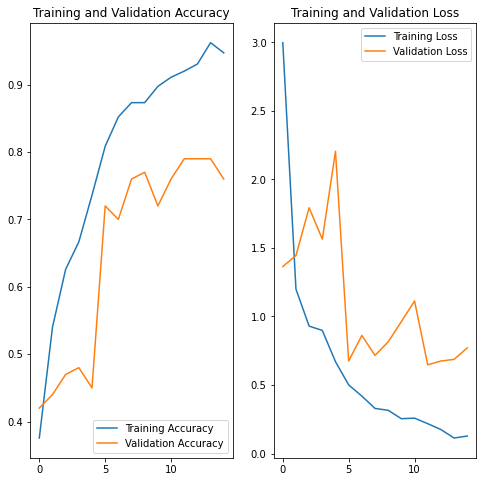

In [15]:
# Firing run and model evaluation

num_epochs1 = 15
history = model_3c.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, 
                                 epochs=num_epochs1, verbose=1, 
                                 callbacks=callbacks_list, validation_data=val_generator, 
                                 validation_steps=validation_steps, class_weight=None,
                                 workers=1, initial_epoch=0)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Store results
results.append(['3d_cnn', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

## CNN-GRU Model Development

In [16]:
# model
sample_shape = [seq_len, img_width, img_height, 3]
no_classes = 5

model_cl = tf.keras.Sequential(
    [layers.TimeDistributed(layers.Conv2D(filters=8, kernel_size=(3,3), activation="relu", padding="same"), input_shape=sample_shape),
     layers.TimeDistributed(layers.MaxPool2D()),
     layers.TimeDistributed(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", padding="same")),
     layers.TimeDistributed(layers.MaxPool2D()),
     layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same")),
     layers.TimeDistributed(layers.MaxPool2D()),
     layers.TimeDistributed(layers.Flatten()),
     layers.Dropout(0.25),
     layers.GRU(16),
     layers.Dropout(0.25),
     layers.Dense(no_classes, activation='softmax')])

In [17]:
# compile model

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cl.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 75, 75, 8)     224       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 37, 37, 8)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 37, 37, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 18, 18, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 18, 18, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 9, 9, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 2592)         

In [18]:
# Define train and validation steps

model_name = 'cnn_gru' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0)
callbacks_list = [checkpoint, LR]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
67/67 [==============================] - 99s 1s/step - loss: 1.5747 - categorical_accuracy: 0.2745 - val_loss: 1.4488 - val_categorical_accuracy: 0.4500
Epoch 2/15
67/67 [==============================] - 96s 1s/step - loss: 1.3262 - categorical_accuracy: 0.4691 - val_loss: 1.1912 - val_categorical_accuracy: 0.6700
Epoch 3/15
67/67 [==============================] - 95s 1s/step - loss: 1.0951 - categorical_accuracy: 0.6078 - val_loss: 1.0637 - val_categorical_accuracy: 0.5900
Epoch 4/15
67/67 [==============================] - 97s 1s/step - loss: 0.8839 - categorical_accuracy: 0.7164 - val_loss: 1.0804 - val_categorical_accuracy: 0.6400
Epoch 5/15
67/67 [==============================] - 94s 1s/step - loss: 0.8325 - categorical_accuracy: 0.7149 - val_loss: 1.0225 - val_categorical_accuracy: 0.6100
Epoch 6/15
67/67 [==============================] - 95s 1s/step - loss: 0.6883 - categorical_accuracy: 0.7903 - val_loss: 0.8483 - val_categorical_accuracy: 0.7000
Epoch 7/15
67/67

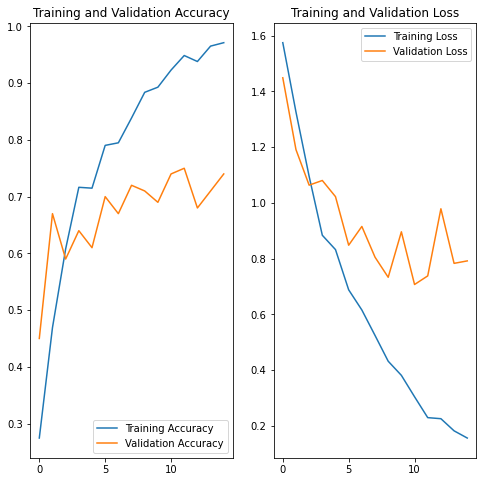

In [19]:
# Firing run and model evaluation

num_epochs2 = 15
history = model_cl.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, 
                                 epochs=num_epochs2, verbose=1, 
                                 callbacks=callbacks_list, validation_data=val_generator, 
                                 validation_steps=validation_steps, class_weight=None,
                                 workers=1, initial_epoch=0)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Store results
results.append(['cnn_gru', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

## Using Data Augmentation

In [20]:
# Defining train and validation generator objects

train_generator1 = generator(train_path, train_doc, batch_size, aug=True)
val_generator1 = generator(val_path, val_doc, batch_size)

## 3D-CNN Model Development

In [21]:
# model
sample_shape = [seq_len, img_width, img_height, 3]
no_classes = 5

model_3c = tf.keras.Sequential(
    [layers.Conv3D(filters=4, kernel_size=(3,3,3), activation="relu", padding="same", input_shape=sample_shape),
     layers.BatchNormalization(),
     layers.MaxPooling3D(),
     layers.Dropout(0.20),
     layers.Conv3D(filters=8, kernel_size=(3,3,3), activation="relu", padding="same", input_shape=sample_shape),
     layers.BatchNormalization(),
     layers.MaxPooling3D(),
     layers.Dropout(0.20),
     layers.Flatten(),
     layers.Dense(128, activation='relu'),
     layers.Dropout(0.25),
     layers.Dense(no_classes, activation='softmax')])


In [22]:
# compile model

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_3c.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3c.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 15, 75, 75, 4)     328       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 75, 75, 4)     16        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 37, 37, 4)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 37, 37, 4)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 37, 37, 8)      872       
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 37, 37, 8)      32        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 3, 18, 18, 8)     

In [23]:
# Store model

model_name = '3d_cnn_aug' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0)
callbacks_list = [checkpoint, LR]

Source path =  Project_data/train ; batch size = 10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
67/67 [==============================] - 127s 2s/step - loss: 2.7961 - categorical_accuracy: 0.3658 - val_loss: 2.2135 - val_categorical_accuracy: 0.3000
Epoch 2/15
67/67 [==============================] - 125s 2s/step - loss: 1.1262 - categorical_accuracy: 0.5513 - val_loss: 3.7727 - val_categorical_accuracy: 0.3400
Epoch 3/15
67/67 [==============================] - 126s 2s/step - loss: 0.9002 - categorical_accuracy: 0.6373 - val_loss: 4.5994 - val_categorical_accuracy: 0.3300
Epoch 4/15
67/67 [==============================] - 126s 2s/step - loss: 0.6808 - categorical_accuracy: 0.7436 - val_loss: 4.7185 - val_categorical_accuracy: 0.3500
Epoch 5/15
67/67 [==============================] - 124s 2s/step - loss: 0.5369 - categorical_accuracy: 0.8024 - val_loss: 2.8743 - val_categorical_accuracy: 0.4700
Epoch 6/15
67/67 [==============================] - 129s 2s/step - loss: 0.4530 - categorical_accuracy: 0.8326 - val_loss: 1.7277 - val_categorical_accuracy: 0.6600
Epoch 7/15

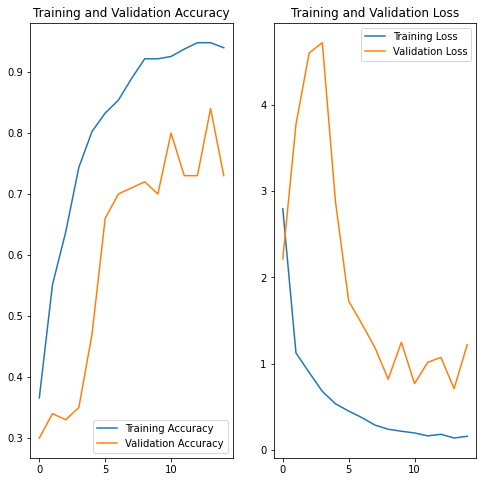

In [24]:
# Firing run and model evaluation

num_epochs1 = 15
history = model_3c.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, 
                                 epochs=num_epochs1, verbose=1, 
                                 callbacks=callbacks_list, validation_data=val_generator1, 
                                 validation_steps=validation_steps, class_weight=None,
                                 workers=1, initial_epoch=0)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Store results
results.append(['3d_cnn_aug', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

## CONV-LSTM Model Development

In [25]:
# model
sample_shape = [seq_len, img_width, img_height, 3]
no_classes = 5

model_cl = tf.keras.Sequential(
    [layers.TimeDistributed(layers.Conv2D(filters=8, kernel_size=(3,3), activation="relu", padding="same"), input_shape=sample_shape),
     layers.TimeDistributed(layers.MaxPool2D()),
     layers.TimeDistributed(layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", padding="same")),
     layers.TimeDistributed(layers.MaxPool2D()),
     layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same")),
     layers.TimeDistributed(layers.MaxPool2D()),
     layers.TimeDistributed(layers.Flatten()),
     layers.Dropout(0.25),
     layers.GRU(16),
     layers.Dropout(0.25),
     layers.Dense(no_classes, activation='softmax')])

In [26]:
# compile model

optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cl.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 15, 75, 75, 8)     224       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 37, 37, 8)     0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 37, 37, 16)    1168      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 18, 18, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 18, 18, 32)    4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 9, 9, 32)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 15, 2592)         

In [27]:
# Define train and validation steps

model_name = 'cnn_gru_aug' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0)
callbacks_list = [checkpoint, LR]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
67/67 [==============================] - 125s 2s/step - loss: 1.5675 - categorical_accuracy: 0.2677 - val_loss: 1.4536 - val_categorical_accuracy: 0.2700
Epoch 2/15
67/67 [==============================] - 124s 2s/step - loss: 1.3493 - categorical_accuracy: 0.4495 - val_loss: 1.3256 - val_categorical_accuracy: 0.4900
Epoch 3/15
67/67 [==============================] - 122s 2s/step - loss: 1.1226 - categorical_accuracy: 0.5633 - val_loss: 1.2974 - val_categorical_accuracy: 0.4300
Epoch 4/15
67/67 [==============================] - 123s 2s/step - loss: 1.0178 - categorical_accuracy: 0.6312 - val_loss: 1.0320 - val_categorical_accuracy: 0.6200
Epoch 5/15
67/67 [==============================] - 120s 2s/step - loss: 0.9203 - categorical_accuracy: 0.6637 - val_loss: 0.8751 - val_categorical_accuracy: 0.7100
Epoch 6/15
67/67 [==============================] - 121s 2s/step - loss: 0.8069 - categorical_accuracy: 0.7112 - val_loss: 0.8571 - val_categorical_accuracy: 0.6900
Epoch 7/15

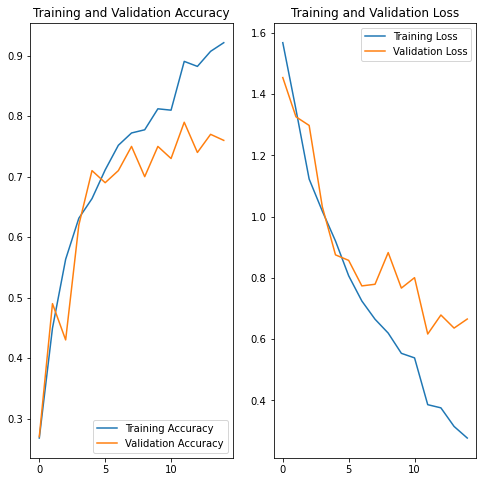

In [28]:
# Firing run and model evaluation

num_epochs2 = 15
history = model_cl.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, 
                                 epochs=num_epochs2, verbose=1, 
                                 callbacks=callbacks_list, validation_data=val_generator1, 
                                 validation_steps=validation_steps, class_weight=None,
                                 workers=1, initial_epoch=0)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Store results
results.append(['cnn_gru_aug', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

In [30]:
# Print results
import pandas as pd
pd.DataFrame(results, columns=['exp', 'acc', 'val_acc', 'loss', 'val_loss'])

,exp,acc,val_acc,loss,val_loss
0,3d_cnn,0.947210,0.76,0.127837,0.770512
1,cnn_gru,0.971342,0.74,0.156598,0.791987
2,3d_cnn_aug,0.939668,0.73,0.160735,1.223034
3,cnn_gru_aug,0.921569,0.76,0.277447,0.665737


# Conclusion

## 3d-CNN Model:
- Model is overfitting with available dataset. We can observe some improvement after data augmentation.


## CNN-GRU:
- Model is overfitting with available dataset. We can observe some improvement after data augmentation.
- Final model (cnn_gru_aug) looks good in terms of overall performance. However further work can be done to avoid overfitting.

-----------------------